# Plant Disease Detection Using MobileNetV2

## Libraries

In [1]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## Visualizing Images

In [2]:
path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
a = 0 
images = []
labels = []
for label in os.listdir(path):
    if label not in labels:
        imgs_path = os.path.join(path,label)
        for j in os.listdir(imgs_path):
            img_path = os.path.join(imgs_path,j)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(512,512))
            img = img/255.0
            images.append(img)
            labels.append(label)
            break

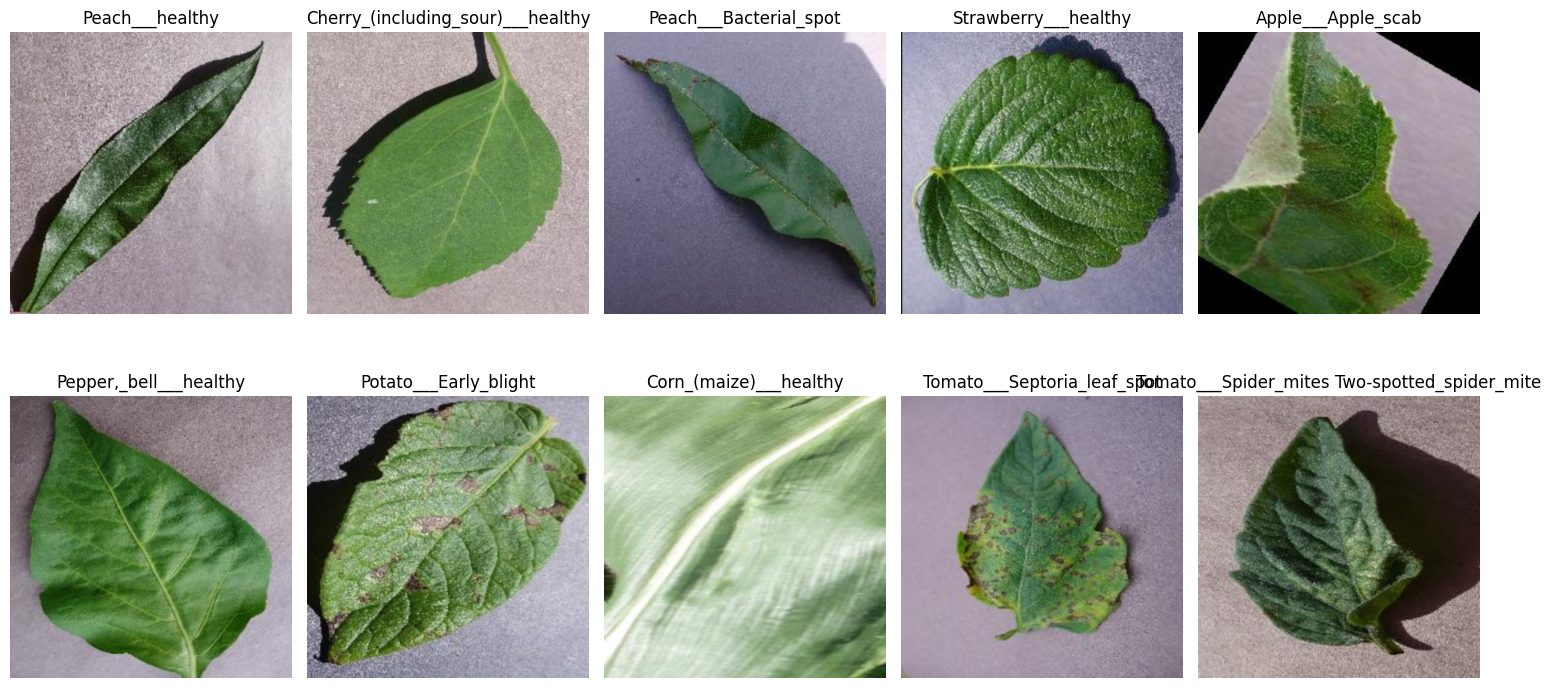

In [3]:
label_indexes = random.sample(labels,10)
indexes = [labels.index(label) for label in label_indexes]
imgs = [images[i] for i in indexes]

fig, axes = plt.subplots(2,5,figsize=(15,8))

axes = axes.flatten()

for i,j in zip(range(len(images)),indexes):
    axes[i].imshow(imgs[i])
    axes[i].set_title(labels[j])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Loading Data

## Scaling

In [4]:
normalize = lambda x,y:(tf.cast(x, tf.float32)/255.0,y) 

## Train

In [5]:
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    seed=123,
    batch_size=20,
    image_size=(224, 224),
    label_mode='categorical')
train_images = train_images.map(normalize)

Found 70295 files belonging to 38 classes.


## Validation

In [6]:
val_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
val_images = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=20,
    seed=123,
    image_size=(224, 224),
    label_mode='categorical')
val_images = val_images.map(normalize)

Found 17572 files belonging to 38 classes.


## Test

In [7]:
test_path = "/kaggle/input/new-plant-diseases-dataset/test/test"
imgs = []
for i in os.listdir(test_path):
    img_path = os.path.join(test_path,i)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    img = img/255.0
    imgs.append(img)
imgs = np.array(imgs)

# Model Builidng (with distributed strategy)

In [8]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    MB_NET= tf.keras.applications.MobileNetV2(weights='imagenet',
                                              classes=38,
                                              include_top=False, 
                                              input_shape=(224,224, 3))
    X = MB_NET.output
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(1024,activation='relu')(X) 
    X = tf.keras.layers.Dense(512,activation='relu')(X) 
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    prediction = tf.keras.layers.Dense(38, activation = 'softmax')(X)
    model = tf.keras.models.Model(inputs=MB_NET.input, outputs=prediction)
    model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary() 

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,116,070 (15.70 MB)

 Trainable params: 4,080,934 (15.57 MB)

 Non-trainable params: 35,136 (137.25 KB)

### Callback

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

## Model Training

In [10]:
history = model.fit(train_images,validation_data=val_images,shuffle=True,epochs=12,batch_size=20,callbacks=[callback])

Epoch 1/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 673s 165ms/step - accuracy: 0.7006 - loss: 1.0224 - val_accuracy: 0.1593 - val_loss: 10.9388
Epoch 2/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 557s 158ms/step - accuracy: 0.8762 - loss: 0.3986 - val_accuracy: 0.4070 - val_loss: 4.6242
Epoch 3/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 558s 159ms/step - accuracy: 0.9115 - loss: 0.2832 - val_accuracy: 0.7521 - val_loss: 1.1705
Epoch 4/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 561s 160ms/step - accuracy: 0.9252 - loss: 0.2390 - val_accuracy: 0.7723 - val_loss: 1.0885
Epoch 5/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 561s 160ms/step - accuracy: 0.9366 - loss: 0.1997 - val_accuracy: 0.7546 - val_loss: 1.1118
Epoch 6/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 560s 159ms/step - accuracy: 0.9470 - loss: 0.1666 - val_accuracy: 0.9149 - val_loss: 0.3560
Epoch 7/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 562s 160ms/step - accuracy: 0.9525 - loss: 0.1506 - val_accuracy: 0.9352 - val_loss: 0.5070
Epoch 8/12
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 561s 159ms/step - a

# Evaluation

In [11]:
val_loss,val_acc = model.evaluate(val_images,batch_size=20)

879/879 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9519 - loss: 0.2997


In [12]:
model.save('model.keras')

## Preparing Data For Evaluation

In [13]:
true_labels = []
predicted_labels = []

for images, labels in val_images:
    true_labels_batch = np.argmax(labels.numpy(), axis=1)
    true_labels.extend(true_labels_batch)
    
    preds_batch = model.predict(images,verbose=0)
    predicted_labels_batch = np.argmax(preds_batch, axis=1)
    predicted_labels.extend(predicted_labels_batch)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

## Metrics

Accuracy: 0.95
Precision (Macro): 0.953
Precision (Weighted): 0.953
Recall (Macro): 0.95
Recall (Weighted): 0.95
F1-Score (Macro): 0.9498
F1-Score (Weighted): 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       504
           1       0.99      0.99      0.99       497
           2       0.96      0.97      0.96       440
           3       0.98      0.89      0.94       502
           4       0.93      1.00      0.96       454
           5       0.97      0.99      0.98       421
           6       0.89      1.00      0.94       456
           7       0.95      0.91      0.93       410
           8       0.96      0.99      0.98       477
           9       0.95      0.96      0.95       477
          10       0.99      0.86      0.92       465
          11       0.85      0.85      0.85       472
          12       0.86      1.00      0.92       480
          13       1.00      0.99      0.99       430
 

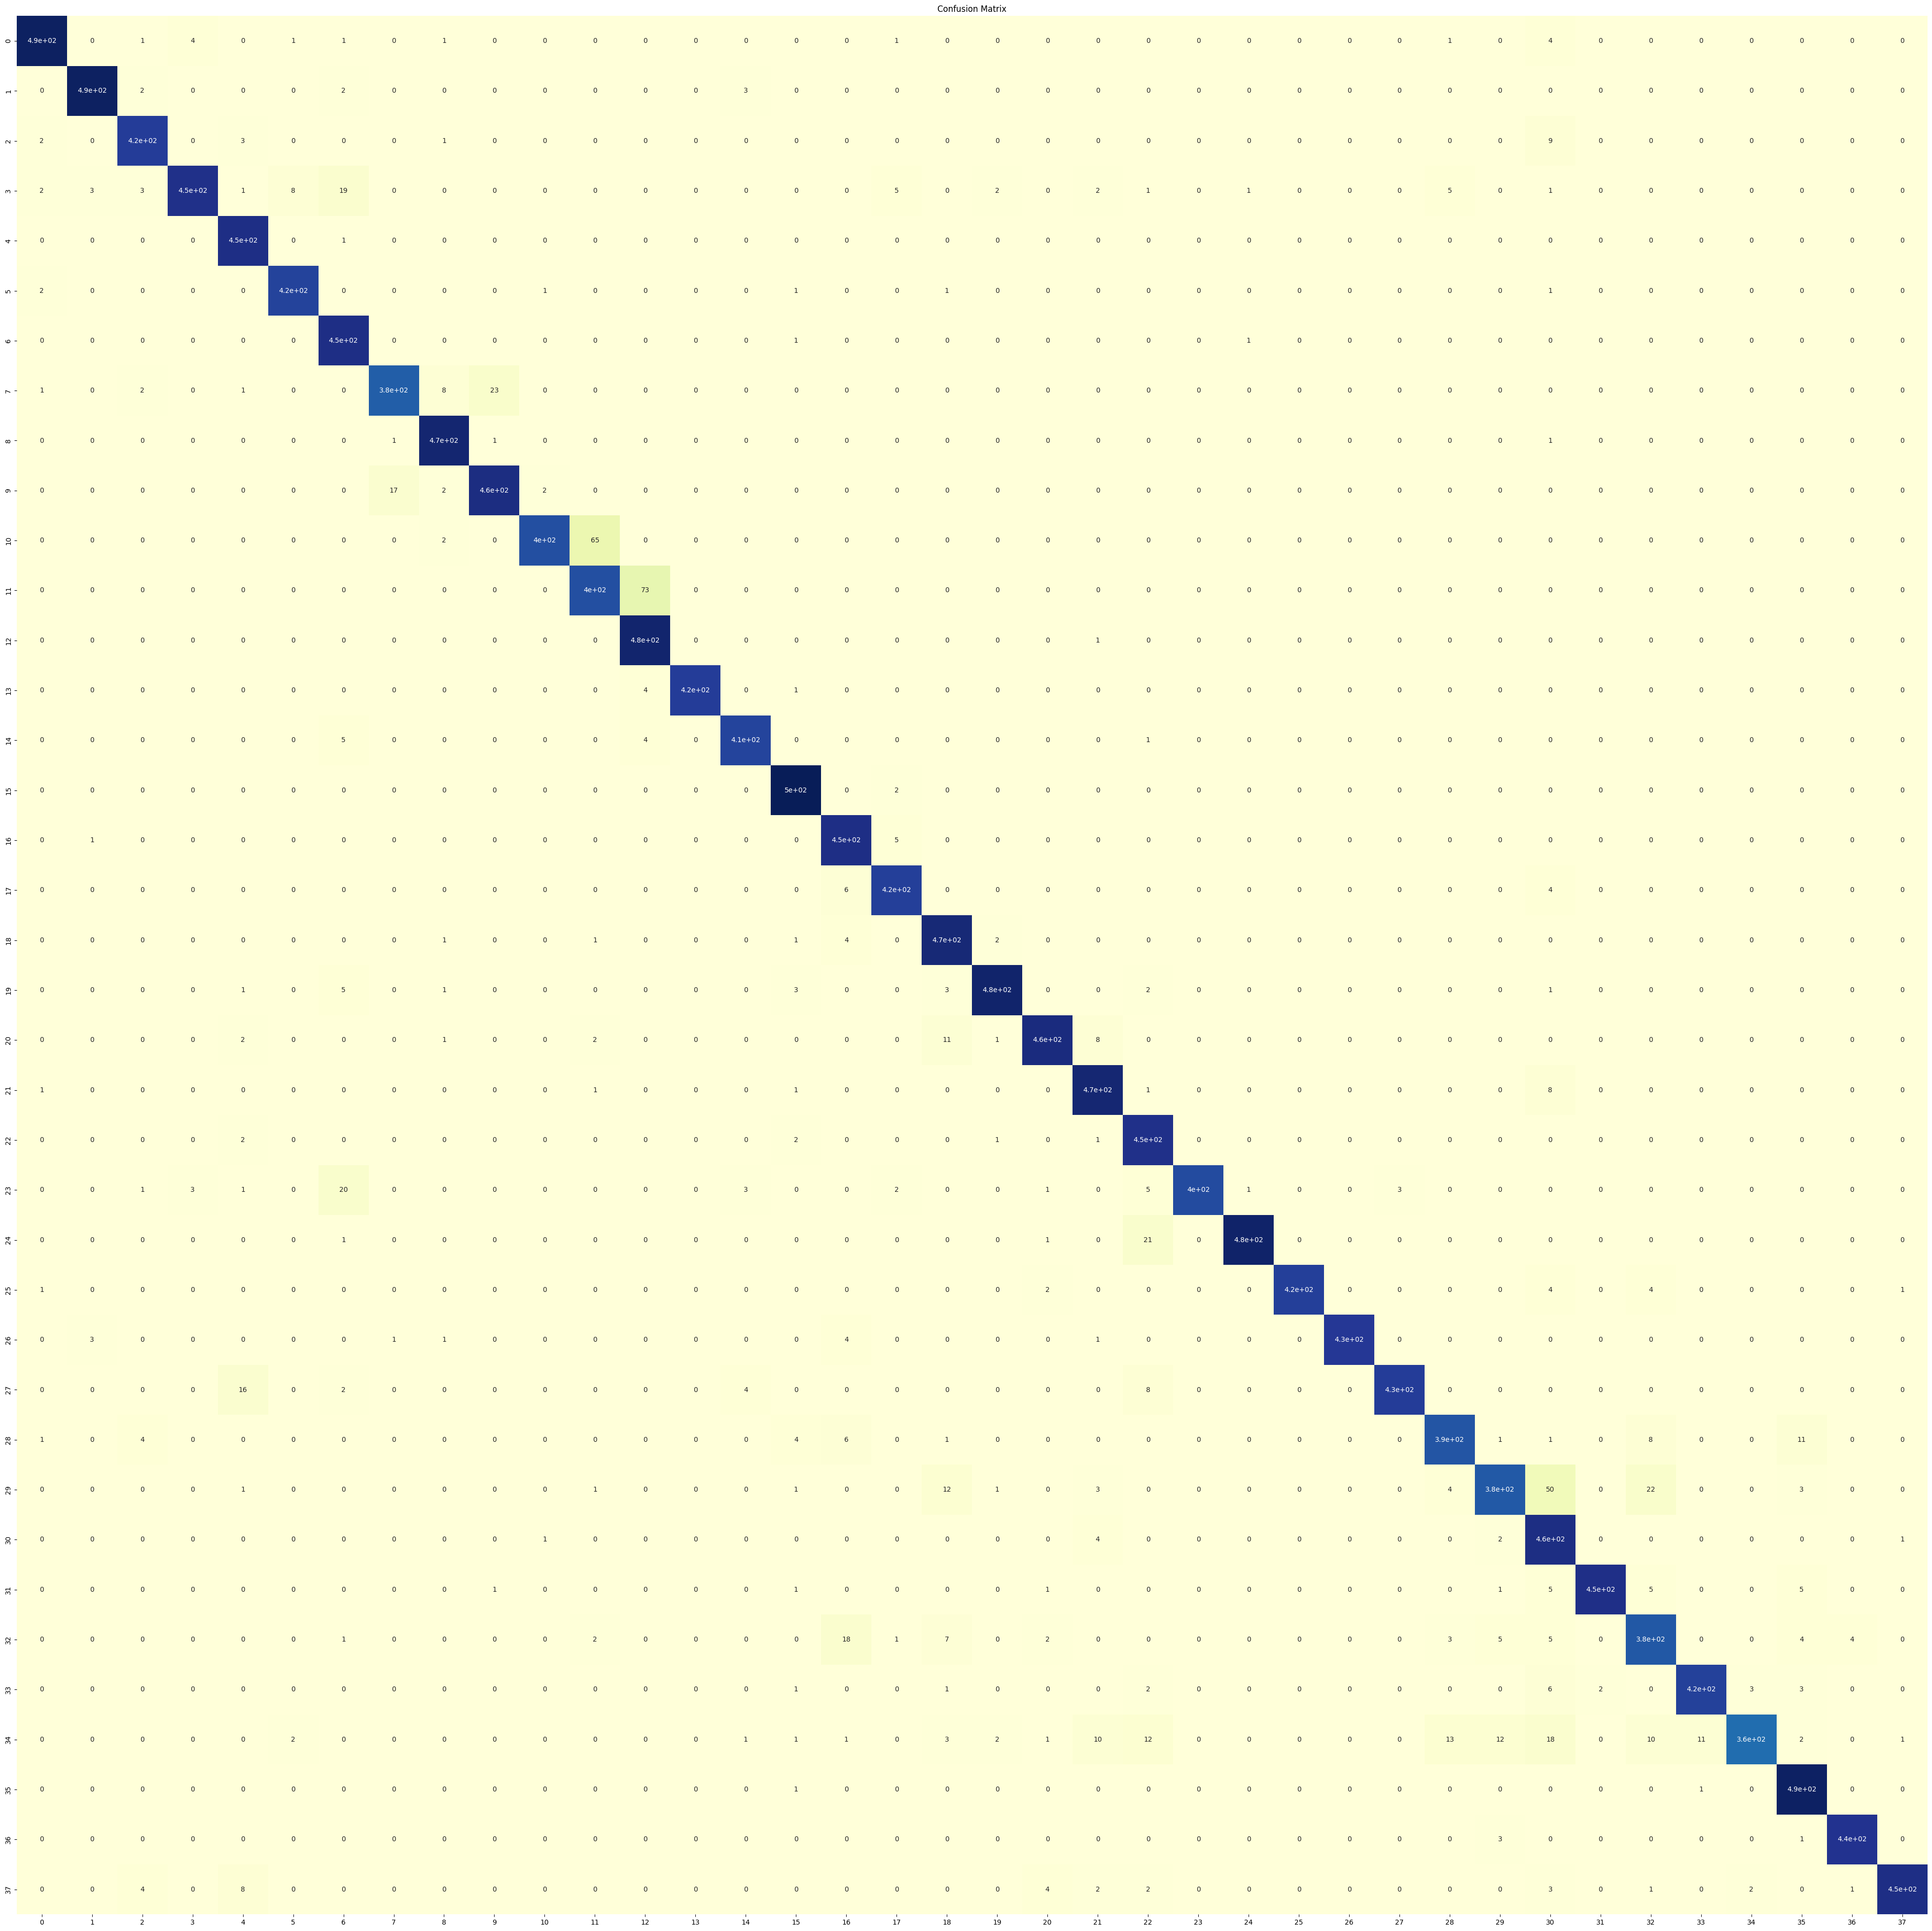

In [14]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", round(accuracy,3))

# Precision (macro-averaged, weighted, and per-class)
precision = precision_score(true_labels, predicted_labels, average='macro')  # Macro-average
precision_weighted = precision_score(true_labels, predicted_labels, average='weighted')  # Weighted-average
print("Precision (Macro):", round(precision,3))
print("Precision (Weighted):", round(precision_weighted,3))

# Recall (macro-averaged, weighted, and per-class)
recall = recall_score(true_labels, predicted_labels, average='macro')
recall_weighted = recall_score(true_labels, predicted_labels, average='weighted')
print("Recall (Macro):", round(recall,3))
print("Recall (Weighted):", round(recall_weighted,3))

# F1-Score (macro-averaged, weighted, and per-class)
f1 = f1_score(true_labels, predicted_labels, average='macro')
f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-Score (Macro):", round(f1,4))
print("F1-Score (Weighted):", round(f1_weighted,3))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(50,50))
plt.title("Confusion Matrix")
sns.heatmap(cm,cbar=False,annot=True,cmap="YlGnBu",fmt=".2g")
# Detailed Classification Report (includes precision, recall, F1-score per class)
report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)